In [1]:
# importing data and auxiliar functions
%load_ext autoreload
%autoreload 2
import saopaulo.sp_grid as gr
import bikescience.distributions as dist
import saopaulo.cycling_potential as cp
import saopaulo.choropleth_folium as choro_folium
import saopaulo.choropleth as choro
from bikescience.slope import plot_slope, plot_slopes, split_route
from shapely.geometry import LineString, Point
import ast
from numpy import nan

import folium
import pandas as pd
import geopandas as gpd
from ipywidgets import interact_manual, widgets, fixed
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import numpy as np
warnings.simplefilter('ignore')

gr.SP_LAT = -23.63
gr.SP_LON = -46.55

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
distritos = [
    'Bela Vista', 'Bom Retiro', 'Cambuci', 'Consolação', 'Liberdade', 
    'República', 'Santa Cecília', 'Sé','Butantã', 'Morumbi', 'Raposo Tavares', 
    'Rio Pequeno', 'Vila Sônia', 'Barra Funda', 'Jaguara', 'Jaguaré', 'Lapa', 
    'Perdizes', 'Vila Leopoldina', 'Alto de Pinheiros', 'Itaim Bibi', 
    'Jardim Paulista', 'Pinheiros','Aricanduva', 'Carrão', 'Vila Formosa',
    'Água Rasa', 'Belém', 'Brás', 'Mooca', 'Pari', 'Tatuapé', 'Artur Alvim',
    'Cangaíba', 'Penha', 'Vila Matilde', 'São Lucas', 'Sapopemba',
    'Vila Prudente','Cidade Tiradentes', 'Ermelino Matarazzo', 'Ponte Rasa',
    'Guaianases', 'Lajeado', 'Itaim Paulista', 'Vila Curuçá', 'Cidade Líder',
    'Itaquera', 'José Bonifácio', 'Parque do Carmo', 'Iguatemi', 'São Mateus',
    'São Rafael', 'Jardim Helena', 'São Miguel', 'Vila Jacuí','Cachoeirinha', 
    'Casa Verde', 'Limão', 'Brasilândia', 'Freguesia do Ó', 'Anhanguera', 
    'Perus', 'Jaraguá', 'Pirituba', 'São Domingos','Jaçanã', 'Tremembé', 
    'Mandaqui', 'Santana', 'Tucuruvi', 'Vila Guilherme', 'Vila Maria', 
    'Vila Medeiros','Cursino', 'Ipiranga', 'Sacomã', 'Jabaquara', 'Moema', 
    'Saúde', 'Vila Mariana', 'Campo Limpo', 'Capão Redondo', 'Vila Andrade', 
    'Cidade Dutra', 'Grajaú', 'Socorro', 'Cidade Ademar', 'Pedreira', 
    'Jardim Ângela', 'Jardim São Luís', 'Marsilac', 'Parelheiros',
    'Campo Belo', 'Campo Grande', 'Santo Amaro']

In [3]:
#read data

#zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
#zone_shp.crs = {'init': 'epsg:31983'}  
#zone_shp.to_crs(epsg='4326', inplace=True)
zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Distritos_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

display(zone_shp)
# converting to km^2
zone_shp['Area_ha_2'] = zone_shp['Area_ha'] / 100
zone_shp['NumeroZona'] = zone_shp['NumeroDist']
zone_shp['NomeZona'] = zone_shp['NomeDistri']
zone_shp['NumeroMuni'] = 0

numeroMuni = []
for _, d in zone_shp.iterrows():
    if d['NomeDistri'] in distritos:
        numeroMuni.append(36)
    else:
        numeroMuni.append(0)
zone_shp['NumeroMuni'] = numeroMuni

# read routes files and join with general trips file
od_trips = pd.read_csv('bases/complete_csv.csv')
# fix FE_VIA with wrong format (because of thousand separator)
od_trips.loc[od_trips['FE_VIA'] >= 10000, 'FE_VIA'] = od_trips.loc[od_trips['FE_VIA'] >= 10000, 'FE_VIA'] / 1000

#od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

od_trips.dropna(inplace = True)

the_grid = gr.create(n=9, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

,NumeroDist,NomeDistri,Area_ha,geometry
0,1,Água Rasa,715.05,"POLYGON ((-46.55380 -23.56843, -46.55387 -23.5..."
1,2,Alto de Pinheiros,751.26,"POLYGON ((-46.69209 -23.54631, -46.69257 -23.5..."
2,3,Anhanguera,3339.95,"POLYGON ((-46.76082 -23.42733, -46.76088 -23.4..."
3,4,Aricanduva,686.26,"POLYGON ((-46.50153 -23.57941, -46.50154 -23.5..."
4,5,Artur Alvim,653.04,"POLYGON ((-46.47300 -23.54029, -46.47302 -23.5..."
...,...,...,...,...
129,130,São Caetano do Sul,1536.53,"POLYGON ((-46.58317 -23.64088, -46.58326 -23.6..."
130,131,São Lourenço da Serra,18674.34,"POLYGON ((-46.98852 -23.79984, -46.98847 -23.7..."
131,132,Suzano,20666.94,"POLYGON ((-46.38321 -23.61775, -46.38318 -23.6..."
132,133,Taboão da Serra,2043.37,"POLYGON ((-46.81819 -23.63701, -46.82138 -23.6..."


In [4]:
od_trips = gpd.GeoDataFrame(od_trips, crs={'init': 'epsg:4326'},
                 geometry=[LineString(eval(r)) for r in od_trips['route']])

In [5]:
# calculate the number of trips that passes through 
def calculate_trips_zone_intersection (trips, zones, reference):
    
    trips_geometries = list(trips['geometry'])
    trips_expansion = list(trips['FE_VIA'])

    trips_per_zone = [0]*len(zone_shp) # hash to store trips indexed by zones

    progress = 0
    
    for z in range(len(zones)):
        zone = zones.iloc[z]['geometry']
        
        if z / len(zones) >= progress:
            print (round(progress * 100), '%')
            progress += 0.25
            
        for i in range (len (trips_geometries)):
            if reference == 'intersection':
                if (trips_geometries[i].intersects(zone)):
                    trips_per_zone[z] += trips_expansion[i]
            else:
                p = trips_geometries[i].coords[reference]
                if (Point(p[0], p[1]).within(zone)):
                    trips_per_zone[z] += trips_expansion[i]
    return trips_per_zone   

def calculate_trips_mean_pot_intersection (trips, zones, potential_label):
    
    trips_geometries = list(trips['geometry'])
    trips_expansion = list(trips['FE_VIA'])
    trips_potential = list(trips[potential_label])

    total_per_zone = [0]*len(zones) # hash to store trips indexed by zones

    progress = 0
    
    for z in range(len(zone_shp)):
        total_trips = 0
        zone = zones.iloc[z]['geometry']
        
        if z / len(zones) >= progress:
            print (round(progress * 100), '%')
            progress += 0.1
            
            
        for i in range (len (trips_geometries)):
            if reference == 'intersection':
                if (trips_geometries[i].intersects(zone)):
                    total_per_zone[z] += trips_expansion[i] * trips_potential[i]
                    total_trips += trips_expansion[i]
            
            else:
                p = trips_geometries[i].coords[reference]
                if (Point(p[0], p[1]).within(zone)):
                    total_per_zone[z] += trips_expansion[i] * trips_potential[i]
                    total_trips += trips_expansion[i]
        
        total_per_zone[z] = 0 if total_trips == 0 else total_per_zone[z] / total_trips
            
    return total_per_zone    

In [6]:
def filter_potential_widgets(btn_text, process_function):
    
    width = '200px'
    layout = widgets.Layout(width = '500px')
    
    im = interact_manual(
        process_function,
        final_potential = widgets.FloatRangeSlider(
            value=[0.8, +1.],
            min=0, max=1., step=0.05,
            description='Final Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        distance_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Distance Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        inclination_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Slope Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        age_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Age Potential:\t',
            style={'description_width': width},
            layout=layout
        ),
        
        modal = widgets.Dropdown(options = [('All', None), ('Car', 'car'), ('Subway', 'subway'),
                                            ('Pedestrian', 'pedestrian'), ('Motorcycle', 'motorcycle'),
                                            ('Train', 'train')],
                                 description = 'Modal', 
                                 style={'description_width': width}),
        reference = widgets.Dropdown(options = [('Whole Trip', 'intersection'),('Origin', 0), 
                                                ('Destination', -1)],
                                     description = 'Trip Reference Point:\t', 
                                     style={'description_width': width}),
        
        density = widgets.Checkbox(description = 'Density'),
        debug = widgets.Checkbox(description = 'Show routes'),
        plot_rmsp = widgets.Checkbox(description = 'Plot SPMA'),
        title = widgets.Text(description = 'Map title', style={'description_width': width}),
    )
    im.widget.children[10].description = btn_text
    
def inside_limits (limits, value):
    return value >= limits[0] and value <= limits[1]
    
def filter_potential(final_potential, distance_potential, age_potential, inclination_potential, modal):
    if modal != None:
        print(modal)
        aux = od_trips.loc[od_trips['modal'] == modal]
    else:
        aux = od_trips
    
    aux = aux.loc[aux['age_potential'] >= age_potential[0]]
    aux = aux.loc[aux['age_potential'] <= age_potential[1]]
    aux = aux.loc[aux['distance_potential'] >= distance_potential[0]]
    aux = aux.loc[aux['distance_potential'] <= distance_potential[1]]
    aux = aux.loc[aux['inclination_potential'] >= inclination_potential[0]]
    aux = aux.loc[aux['inclination_potential'] <= inclination_potential[1]]
    aux = aux.loc[aux['final_potential'] >= final_potential[0]]
    aux = aux.loc[aux['final_potential'] <= final_potential[1]]
    return aux

In [7]:
def plot_potential_trips_per_zone(final_potential, distance_potential, inclination_potential, age_potential, 
                                  modal, reference, 
                                  debug=False, plot_rmsp = False, density = False,
                                  title = None):
    df = filter_potential(final_potential, distance_potential, age_potential, inclination_potential, modal)
    
    global global_df 
    global_df = df
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if not plot_rmsp else zone_shp
    
    trips_per_zone = calculate_trips_zone_intersection(df, zones, reference)
    
    if density:
        df_total = od_trips if modal == None else od_trips.loc[od_trips['modal'] == modal]
        total_per_zone = calculate_trips_zone_intersection(df_total, zones, reference)
        perc = [0 if total_per_zone[i] == 0 else trips_per_zone[i] / total_per_zone[i] * 100
                for i in range(len(zone_shp))]
        zone_shp['potential_trips'] = perc
        
    else:
        zone_shp['potential_trips'] = trips_per_zone

    # precisa filtrar de novo pra plotar
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if not plot_rmsp else zone_shp
    
    tooltip_columns = ['NomeZona', 'potential_trips']
    tooltip_aliases = ['District', 'Potential Trips']
    fmap = gr.map_around_sp(the_grid=None,zoom=10,plot_grid=False)
    choro_folium.plot_choropleth(fmap, title, 'YlOrBr', lambda x : x['potential_trips'], 
                          zones, tooltip_columns, tooltip_aliases, plot_rmsp)
    
    if debug:
        #display(df)
        plot_slopes (fmap, df['geometry'], 1000, False)
    
    display(fmap)


In [9]:
filter_potential_widgets('Filter trips', plot_potential_trips_per_zone)

interactive(children=(FloatRangeSlider(value=(0.8, 1.0), description='Final Potential:\t', layout=Layout(width…

In [133]:
global global_df
modals = od_trips.drop_duplicates('modal')['modal']
total = sum(od_trips.loc[od_trips['final_potential'] >= 0.8]['FE_VIA'])
for m in modals:
    aux = od_trips.loc[od_trips['modal'] == m].loc[od_trips['final_potential'] >= 0.8]
    trips = sum(aux['FE_VIA'])
    print(m, round(trips, 2), round(trips / total, 2), sep='\t')

#display(global_df)

pedestrian	1385859.59	0.53
subway	89432.59	0.03
bus_sp	250010.11	0.1
taxi_app	20399.41	0.01
car	629404.07	0.24
bus_private	14072.01	0.01
train	36237.21	0.01
taxi	5070.22	0.0
bus_school	8260.61	0.0
other	6720.22	0.0
motorcycle	78400.0	0.03
bus_inter	25928.93	0.01
bus_otherc	54660.44	0.02
monorail	2087.57	0.0


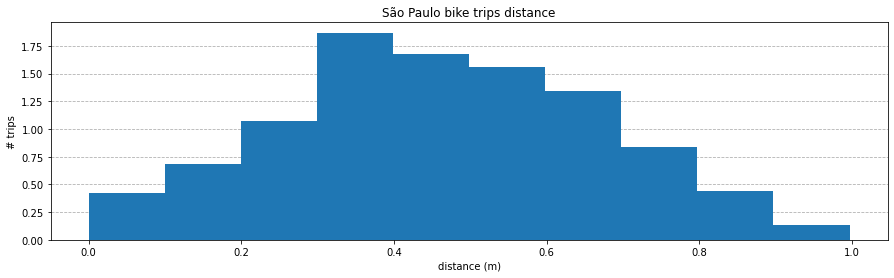

(0.05, 2.012956312904005)
(0.15000000000000002, 3.2684730918259897)
(0.25, 5.124345344052858)
(0.35000000000000003, 8.90203916023399)
(0.45, 7.912774074367049)
(0.55, 7.396443134561996)
(0.65, 6.335741710492963)
(0.75, 3.9179749300519617)
(0.85, 2.0179569789170038)
(0.95, 0.5885859889900017)
(1.0499999999999998, 0.0)
-------------------


In [90]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10, x=od_trips['final_potential'], 
         weights = od_trips['FE_VIA'], cumulative = 0, density = True)
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.savefig('./images/bike_trips_distance_gender')
plt.show()

for s in [1]:
    age = 0
    while age <= 1:
        cyclists = sum(od_trips
                       .loc[od_trips['final_potential'] >= age]
                       .loc[od_trips['final_potential'] < age + .1]['FE_VIA'])
        #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
        print('(' + str(age + .05) + ', ' + str(cyclists / 10**6) + ')')
        age += .1
    print ('-------------------')

In [13]:
def plot_potential_mean_widgets():
    im = interact_manual(
        plot_potential_mean,
        variable = widgets.Dropdown(options = [('Final', 'final_potential'), 
                                               ('Distance', 'distance_potential'), 
                                               ('Age', 'age_potential'), 
                                               ('Inclination', 'inclination_potential')],
                                    description = 'Potential Variable', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px')),
        reference = widgets.Dropdown(options = [('Origin', 0), ('Destination', -1), 
                                                ('Whole Trip', 'intersection')],
                                     description = 'Trip Reference Point:\t', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px')),
        
        modal = widgets.Dropdown(options = [('All', None), ('Car', 'car'), ('Subway', 'subway'),
                                            ('Pedestrian', 'pedestrian'), ('Motorcycle', 'motorcycle'),
                                            ('Train', 'train')],
                                 description = 'Modal', 
                                    style={'description_width': '300px'},
                                    layout = widgets.Layout(width = '500px'))
    )
    im.widget.children[4].description = 'Plot Map'
    
def plot_potential_mean(variable, reference, modal, only_sp = True):
    trips = [0]*len(zone_shp)
    potential = [0]*len(zone_shp)
    
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp

    if modal != None:
        aux = od_trips.loc[od_trips['modal'] == modal]
    else:
        aux = od_trips
        
    if reference == 'intersect':
        mean = calculate_trips_mean_pot_intersection(aux, 
                                                    zones, variable)
    else:
        for i, t in aux.iterrows():
            potential[int(t[reference] - 1)] += t[variable] * t['FE_VIA']
            trips[int(t[reference] - 1)] += t['FE_VIA']

        mean = [0 if trips[i] == 0 else potential[i] / trips [i] for i in range(517)]
    
    zone_shp['mean_potential'] = mean
    zones = zone_shp.loc[zone_shp["NumeroMuni"] == 36] if only_sp else zone_shp

    tooltip_columns = ['NomeZona', 'mean_potential']
    tooltip_aliases = ['Zone', 'Mean Potential (' + reference + ')']
    fmap = gr.map_around_sp(the_grid=None,zoom=10,plot_grid=False)
    choro_folium.plot_choropleth(fmap, 'Mean Potential (' + reference + ') ' + ' (' + variable + ')', 
                                 'YlOrBr', lambda x : x['mean_potential'], 
                          zones, tooltip_columns, tooltip_aliases)
    display(fmap)

In [78]:
plot_potential_mean_widgets()

interactive(children=(Dropdown(description='Potential Variable', layout=Layout(width='500px'), options=(('Fina…

In [79]:
# jeito automático de calcular as interseções, faz o kernel morrer :(

#lines_per_polygon = gpd.overlay(od_trips, zone_shp, how = 'intersection')
#display(lines_per_polygon)

#lines_per_polygon = lines_per_polygon[['NumeroZona', 'FE_VIA', 'final_potential']]
#lines_per_polygon = lines_per_polygon.groupby(['NumeroZona'], as_index=False).sum()
#return geodf_polygons.merge(right = lines_per_polygon, on = polygon_id_column,
#                               how = 'left', suffixes = ("", "")).fillna(0)